In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import numpy as np
import xarray as xr
from util import *

In [2]:
times=[4,7]
timeStr=['400 s','700 s','743 s']

hgt_c=[ 2.12]
# hgt_c=[ 10]
deviatoric=True

paths=[ '../cases/SBL_local_midGridReInterp/'] #'../cases/SBL_global_midGridReInterp/',
pathLabels=['Local'] # 'Global',


varStr=['u','v','w','b']
size=1
xList_local = []
yList_local = []
scalesList = []
for iLES, path in enumerate(paths):
    
    # open_mfdatset not working with this version of xarray for some reason, 
    # could install dask to fix error judging by error message
    uda=xr.open_dataset(path+varStr[0]+'.nc')[varStr[0]]
    print(uda)
    vda=xr.open_dataset(path+varStr[1]+'.nc')[varStr[1]]
    print(vda)
    wda=xr.open_dataset(path+varStr[2]+'.nc')[varStr[2]]
    print(wda)
    bda=xr.open_dataset(path+varStr[3]+'.nc')[varStr[3]]
    print(bda)
    
    # Getting grid vairables to comput grid size
    x=vda['x'].values
    y=uda['y'].values
    nbl=int(0.75*uda.shape[1])
    z=uda['z'].values[:nbl]
    dx=np.mean(np.diff(x))
    dy=np.mean(np.diff(y))
    dz=np.mean(np.diff(z))


    # Getting input variables, removing laminar layers, wrapping periodic varaibles as reordering to x,y,z,t 
    uwrap=uda[times,0:nbl].pad(xh=(1,0), mode='wrap')
    ucenter=0.5*(uwrap[:,:,:,1:].assign_coords(xh=vda['x'].values)+uwrap[:,:,:,:-1].assign_coords(xh=vda['x'].values))
    uc=ucenter.pad({'xh':(size,size),'y':(size,size)},mode='wrap').transpose().values
    u=box(uc)

    vwrap=vda[times,0:nbl].pad(yh=(1,0), mode='wrap')
    vcenter=0.5*(vwrap[:,:,1:,:].assign_coords(yh=uda['y'].values)+vwrap[:,:,:-1,:].assign_coords(yh=uda['y'].values))
    vc=vcenter.pad({'x':(size,size),'yh':(size,size)},mode='wrap').transpose().values
    v=box(vc)

    wpad=wda[:,0:nbl+1]
    wcenter=0.5*(wpad[times,1:,:,:].assign_coords(zh=z)+wpad[:,:-1,:,:].assign_coords(zh=z))
    wc=wcenter.pad({'x':(size,size),'y':(size,size)},mode='wrap').transpose().values
    w=box(wc)
    
    b=box(bda[times,0:nbl].pad({'x':(size,size),'y':(size,size)},mode='wrap').transpose().values)

    inputFields = np.array([u, v, w, b])
    
    #Gradients at grid scale for strain rate
    # d11=(uc[2:,1:-1,:,:]-uc[:-2,1:-1,:,:])/(2*dx)
    # d12=(uc[1:-1,2:,:,:]-uc[1:-1,:-2,:,:])/(2*dy)
    # d13=np.gradient(uc[1:-1,1:-1,:,:],dz,axis=2)
    
    # d21=(vc[2:,1:-1,:,:]-vc[:-2,1:-1,:,:])/(2*dx)
    # d22=(vc[1:-1,2:,:,:]-vc[1:-1,:-2,:,:])/(2*dy)
    # d23=np.gradient(vc[1:-1,1:-1,:,:],dz,axis=2)
    
    # d31=(wc[2:,1:-1,:,:]-wc[:-2,1:-1,:,:])/(2*dx)
    # d32=(wc[1:-1,2:,:,:]-wc[1:-1,:-2,:,:])/(2*dy)
    # d33=np.gradient(wc[1:-1,1:-1,:,:],dz,axis=2)

    # S11=d11
    # S12=0.5*(d12+d21)
    # S13=0.5*(d13+d31)
    # S22=d22
    # S23=0.5*(d23+d32)
    # S33=d33

    #Gradients at filter scale for TKE, TPE, and N2
    d11=(u[2:,1:-1,:,:]-u[:-2,1:-1,:,:])/(2*dx)
    d12=(u[1:-1,2:,:,:]-u[1:-1,:-2,:,:])/(2*dy)
    d13=np.gradient(u[1:-1,1:-1,:,:],dz,axis=2)

    d21=(v[2:,1:-1,:,:]-v[:-2,1:-1,:,:])/(2*dx)
    d22=(v[1:-1,2:,:,:]-v[1:-1,:-2,:,:])/(2*dy)
    d23=np.gradient(v[1:-1,1:-1,:,:],dz,axis=2)

    d31=(w[2:,1:-1,:,:]-w[:-2,1:-1,:,:])/(2*dx)
    d32=(w[1:-1,2:,:,:]-w[1:-1,:-2,:,:])/(2*dy)
    d33=np.gradient(w[1:-1,1:-1,:,:],dz,axis=2)

    # Strain at fitler scale, maybe better comparison to coarsened DNS
    S11=d11
    S12=0.5*(d12+d21)
    S13=0.5*(d13+d31)
    S22=d22
    S23=0.5*(d23+d32)
    S33=d33

        # Copmute anisotropic local scaling factors
    TKE_h = dx**2*(d11**2 + d21**2) + dy**2*(d12**2 + d22**2) + dz**2*(d13**2 + d23**2) 
    TKE_v = dx**2*d31**2 + dy**2*d32**2 + dz**2*d33**2
    TKE = TKE_h + TKE_v
    #TKE = (delta**2/1.0)*dijdij
    del d11,d12,d13,d21,d22,d23,d31,d32,d33#,TKE_h

    db1=(b[2:,1:-1,:,:]-b[:-2,1:-1,:,:])/(2*dx)
    db2=(b[1:-1,2:,:,:]-b[1:-1,:-2,:,:])/(2*dy)
    db3=np.gradient(b[1:-1,1:-1,:,:],dz,axis=2)
    N2=db3
    
    #dbkdbk=db1*db1+db2*db2+db3*db3
    TPE=(dx**2*db1**2+dy**2*db2**2+dz**2*db3**2)/N2
    #TPE = (delta**2/1.0)*dbkdbk/N2
    del db1,db2,db3 
    gc.collect()

    hvelScale = np.pad(np.sqrt(TKE),((size,size),(size,size),(0,0),(0,0)),mode='wrap')
    vvelScale = np.pad(np.sqrt(TKE_v),((size,size),(size,size),(0,0),(0,0)),mode='wrap')
    bScale = np.pad(TPE/dz,((size,size),(size,size),(0,0),(0,0)),mode='wrap')
    TKEf=box(TKE,koffset=1,pad=False)
    TKEvf=box(TKE_v,koffset=1,pad=False)
    ti3Scale=np.sqrt(TKEf*TKEvf)
    tijScale=np.array([TKEf,TKEf,ti3Scale,TKEf,ti3Scale,TKEvf])
    # ti3Scale=np.sqrt(TKE*TKE_v)
    # tijScale=np.array([TKE,TKE,ti3Scale,TKE,ti3Scale,TKE_v])

    for it in range(inputFields.shape[4]):
        for i in range(size, inputFields.shape[1] - size):
            for j in range(size, inputFields.shape[2] - size):
                for k in range(size, inputFields.shape[3] - size):                
                    ## Local Scaling 
                    scaledInput=[scale(inputFields[0,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=hvelScale[i, j, k, it]),
                                 scale(inputFields[1,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=hvelScale[i, j, k, it]),
                                 scale(inputFields[2,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=vvelScale[i, j, k, it]),
                                 scale(inputFields[3,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=bScale[i, j, k, it])]
                    xList_local.append(scaledInput)
                    scalesList.append(tijScale[:,i-size,j-size,k,it])
                    # yList_local.append(outputFields[:,i-size,j-size,k,it]/tijScale[:,i-size,j-size,k,it])

x3d=np.array(xList_local)
scales=np.array(scalesList)
xlocal=myreshape(x3d,size=2*size+1)

<xarray.DataArray 'u' (time: 8, z: 64, y: 32, xh: 32)> Size: 4MB
[524288 values with dtype=float64]
Coordinates:
  * time     (time) float64 64B 0.0 100.0 200.0 300.0 400.0 500.0 600.0 700.0
  * z        (z) float64 512B 0.1412 0.4236 0.706 0.9885 ... 17.37 17.65 17.93
  * y        (y) float64 256B 0.4279 1.284 2.14 2.995 ... 24.39 25.25 26.1 26.96
  * xh       (xh) float64 256B 0.0 0.8558 1.712 2.567 ... 24.82 25.67 26.53
<xarray.DataArray 'v' (time: 8, z: 64, yh: 32, x: 32)> Size: 4MB
[524288 values with dtype=float64]
Coordinates:
  * time     (time) float64 64B 0.0 100.0 200.0 300.0 400.0 500.0 600.0 700.0
  * z        (z) float64 512B 0.1412 0.4236 0.706 0.9885 ... 17.37 17.65 17.93
  * x        (x) float64 256B 0.4279 1.284 2.14 2.995 ... 24.39 25.25 26.1 26.96
  * yh       (yh) float64 256B 0.0 0.8558 1.712 2.567 ... 24.82 25.67 26.53
<xarray.DataArray 'w' (time: 8, zh: 64, y: 32, x: 32)> Size: 4MB
[524288 values with dtype=float64]
Coordinates:
  * time     (time) float64 64B 0

In [3]:
path="/glade/u/home/adac/work/DNStoLES/coarseData/"
# files=[ "coarse4x513_Re900.nc","coarse4x1026_Re1800.nc","coarse4x1539_Re2700.nc",
#         "coarse4x1026_Re900.nc","coarse4x2052_Re1800.nc","coarse4x3078_Re2700.nc",
#         "coarse4x2052_Re900.nc","coarse4x40104_Re1800.nc","coarse4x60156_Re2700.nc"]
# files=["coarse4x1026_Re900.nc","coarse4x2052_Re1800.nc","coarse4x3078_Re2700.nc"]
# fileUgs=[0.025,0.05,0.075]
# fileRes=[20000.,40000.,60000.]
# fileb0s=[0.0005, 0.0044, 0.0349]
files=["coarse4x2052_Re1800.nc"]
fileUgs=[0.05]
fileRes=[40000.]
fileb0s=[0.0044]
fileMaskPercents=[1]

In [4]:
# xList_local = []
# xList_global = []
# xList_unscaled = []
# yList_local = []
# yList_global = []
yList_unscaled = []

size=1
for ifile in range(len(files)): #tdqm notebook just draws progress bar
    file=files[ifile] 
    ds=xr.open_dataset(path+file,decode_times=0)
    print(ds)

    # Getting input variables, removing laminar layers, wrapping periodic varaibles as reordering to x,y,z,t 
    b=np.transpose(np.pad(cut_laminar(ds['b'].values[:,:,:,times]),((0,0),(size,size),(size,size),(0,0)),mode='wrap'), [2, 1, 0,3])
    u=np.transpose(np.pad(cut_laminar(ds['u'].values[:,:,:,times]),((0,0),(size,size),(size,size),(0,0)),mode='wrap') , [2, 1, 0,3])
    v=np.transpose(np.pad(cut_laminar(ds['v'].values[:,:,:,times]),((0,0),(size,size),(size,size),(0,0)),mode='wrap'), [2, 1, 0,3])
    w=np.transpose(np.pad(cut_laminar(ds['w'].values[:,:,:,times]),((0,0),(size,size),(size,size),(0,0)),mode='wrap'), [2, 1, 0,3])
    inputFields = np.array([u, v, w, b])
   
    # Getting output fields
    tau_12 = np.transpose(cut_laminar(ds['tau12'].values[:,:,:,times]), [2, 1, 0,3])
    tau_13 = np.transpose(cut_laminar(ds['tau13'].values[:,:,:,times]), [2, 1, 0,3])
    tau_23 = np.transpose(cut_laminar(ds['tau23'].values[:,:,:,times]), [2, 1, 0,3])
    tau_11 = np.transpose(cut_laminar(ds['tau11'].values[:,:,:,times]), [2, 1, 0,3])
    tau_22 = np.transpose(cut_laminar(ds['tau22'].values[:,:,:,times]), [2, 1, 0,3])
    tau_33 = np.transpose(cut_laminar(ds['tau33'].values[:,:,:,times]), [2, 1, 0,3])
    outputFields = np.array([tau_11,tau_12, tau_13, tau_22, tau_23, tau_33])

    # Getting grid vairables to comput grid size
    x=ds['x'].values
    y=ds['y'].values
    z=cut_laminar(ds['z'].values)
    dx=np.mean(np.diff(x))
    dy=np.mean(np.diff(y))
    dz=np.mean(np.diff(z))
    #delta=(dx*dy*dz)**(1.0/3.0)

    # Computing gradients for scaling saling variables: TKE, TPE, and N2
    d11=(u[2:,1:-1,:,:]-u[:-2,1:-1,:,:])/(2*dx)
    d12=(u[1:-1,2:,:,:]-u[1:-1,:-2,:,:])/(2*dy)
    d13=np.gradient(u[1:-1,1:-1,:,:],dz,axis=2)

    d21=(v[2:,1:-1,:,:]-v[:-2,1:-1,:,:])/(2*dx)
    d22=(v[1:-1,2:,:,:]-v[1:-1,:-2,:,:])/(2*dy)
    d23=np.gradient(v[1:-1,1:-1,:,:],dz,axis=2)

    d31=(w[2:,1:-1,:,:]-w[:-2,1:-1,:,:])/(2*dx)
    d32=(w[1:-1,2:,:,:]-w[1:-1,:-2,:,:])/(2*dy)
    d33=np.gradient(w[1:-1,1:-1,:,:],dz,axis=2)
    
    S11_true=d11
    S12_true=0.5*(d12+d21)
    S13_true=0.5*(d13+d31)
    S22_true=d22
    S23_true=0.5*(d23+d32)
    S33_true=d33
    
    # Copmute anisotropic local scaling factors
    # TKE_h = dx**2*(d11**2 + d21**2) + dy**2*(d12**2 + d22**2) + dz**2*(d13**2 + d23**2) 
    # TKE_v = dx**2*d31**2 + dy**2*d32**2 + dz**2*d33**2
    # TKE = TKE_h + TKE_v
    # #TKE = (delta**2/1.0)*dijdij
    # del d11,d12,d13,d21,d22,d23,d31,d32,d33#,TKE_h

    # db1=(b[2:,1:-1,:,:]-b[:-2,1:-1,:,:])/(2*dx)
    # db2=(b[1:-1,2:,:,:]-b[1:-1,:-2,:,:])/(2*dy)
    # db3=np.gradient(b[1:-1,1:-1,:,:],dz,axis=2)
    # N2=db3
    
    # db1=(b[2:,1:-1,:,:]-b[:-2,1:-1,:,:])/(2*dx)
    # db2=(b[1:-1,2:,:,:]-b[1:-1,:-2,:,:])/(2*dy)
    # db3=np.gradient(b[1:-1,1:-1,:,:],dz,axis=2)
    # N2=db3
    # #dbkdbk=db1*db1+db2*db2+db3*db3
    # TPE=(dx**2*db1**2+dy**2*db2**2+dz**2*db3**2)/N2
    # #TPE = (delta**2/1.0)*dbkdbk/N2
    # del db1,db2,db3 
    # gc.collect()

    # hvelScale = np.pad(np.sqrt(TKE),((size,size),(size,size),(0,0),(0,0)),mode='wrap')
    # vvelScale = np.pad(np.sqrt(TKE_v),((size,size),(size,size),(0,0),(0,0)),mode='wrap')
    # bScale = np.pad(TPE/dz,((size,size),(size,size),(0,0),(0,0)),mode='wrap')
    # ti3Scale=np.sqrt(TKE*TKE_v)
    # tijScale=np.array([TKE,TKE,ti3Scale,TKE,ti3Scale,TKE_v])

    for it in range(inputFields.shape[4]):
        for i in range(size, inputFields.shape[1] - size):
            for j in range(size, inputFields.shape[2] - size):
                for k in range(size, inputFields.shape[3] - size):                
                    ## No normalization
                    # scaledInput=[scale(inputFields[0,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=1),
                    #              scale(inputFields[1,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=1),
                    #              scale(inputFields[2,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=1),
                    #              scale(inputFields[3,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=1)]
                    # xList_unscaled.append(scaledInput)
                    yList_unscaled.append(outputFields[:,i-size,j-size,k,it])
                    
                    # ## Local Scaling 
                    # scaledInput=[scale(inputFields[0,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=hvelScale[i, j, k, it]),
                    #              scale(inputFields[1,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=hvelScale[i, j, k, it]),
                    #              scale(inputFields[2,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=vvelScale[i, j, k, it]),
                    #              scale(inputFields[3,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=bScale[i, j, k, it])]
                    # xList_local.append(scaledInput)
                    # yList_local.append(outputFields[:,i-size,j-size,k,it]/tijScale[:,i-size,j-size,k,it])
                    # scalesList.append([TKE[i-size,j-size,k,it],TKE_h[i-size,j-size,k,it],TKE_v[i-size,j-size,k,it],TPE[i-size,j-size,k,it]])


                    # yList_local.append(outputFields[:,i-size,j-size,k,it]/tijScale[:,i-size,j-size,k,it])

                    ## Global Scaling
                    # scaledInput=[scale(inputFields[0,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=fileUgs[ifile]/np.sqrt(fileRes[ifile])),
                    #              scale(inputFields[1,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=fileUgs[ifile]/np.sqrt(fileRes[ifile])),
                    #              scale(inputFields[2,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=fileUgs[ifile]/np.sqrt(fileRes[ifile])),
                    #              scale(inputFields[3,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=fileb0s[ifile])]
                    # xList_global.append(scaledInput)
                    # yList_global.append(outputFields[:,i-size,j-size,k,it]*fileRes[ifile]/fileUgs[ifile]**2)
                        
                        
    
# xlocal=np.array(xList_local)
# xglobal=np.array(xList_global)
# del xList_global
# xtrue=np.array(xList_unscaled)
# del xList_unscaled
# ylocal=np.array(yList_local)
# del yList_local
# yglobal=np.array(yList_global)
# del yList_global
yunscaled=np.array(yList_unscaled)
del yList_unscaled
# scales=np.array(scalesList)

<xarray.Dataset> Size: 110MB
Dimensions:  (z: 64, y: 32, x: 32, time: 15)
Coordinates:
  * z        (z) float64 512B 0.5648 0.8473 1.13 1.412 ... 17.79 18.07 18.36
  * y        (y) float64 256B 0.4279 1.284 2.14 2.995 ... 24.39 25.25 26.1 26.96
  * x        (x) float64 256B 0.4279 1.284 2.14 2.995 ... 24.39 25.25 26.1 26.96
  * time     (time) int64 120B 616000 617000 618000 ... 628000 629000 630000
Data variables: (12/14)
    u        (z, y, x, time) float64 8MB ...
    v        (z, y, x, time) float64 8MB ...
    w        (z, y, x, time) float64 8MB ...
    tau11    (z, y, x, time) float64 8MB ...
    tau22    (z, y, x, time) float64 8MB ...
    tau33    (z, y, x, time) float64 8MB ...
    ...       ...
    tau23    (z, y, x, time) float64 8MB ...
    b        (z, y, x, time) float64 8MB ...
    ub       (z, y, x, time) float64 8MB ...
    vb       (z, y, x, time) float64 8MB ...
    wb       (z, y, x, time) float64 8MB ...
    p        (z, y, x, time) float64 8MB ...


In [5]:
def get_xyplane_true(y,nx,ny,nz,nt,kplot,tplot,krot=0):
    xyplane=np.empty((nx,ny,y.shape[1]))
    for i in range(nx):
        for j in range(ny):
            xyplane[i,j]=y[tplot*nx*ny*nz+i*ny*nz+j*nz+(kplot-1)]
    
    return np.rot90(xyplane,k=krot)

def get_xyplane_model(model,x,scale,nx,ny,nz,nt,kplot,tplot,krot=0):
    xyplane=np.empty((nx,ny,6))
    for i in range(nx):
        for j in range(ny):            
            xyplane[i,j]=model(torch.from_numpy(x[tplot*nx*ny*nz+i*ny*nz+j*nz+(kplot-1)]).float().unsqueeze(0).to(device)).detach().cpu().numpy().squeeze()
            xyplane[i,j]=xyplane[i,j]*scale[tplot*nx*ny*nz+i*ny*nz+j*nz+(kplot-1)]
            # kplot - 1 because x does not have the k=0 from the orginal arrays
    return np.rot90(xyplane,k=krot)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
Nhid=[512,256,128,64]
model=CNDNN(Nhid,4,3,device).float()

cpu


In [7]:
size=3
loadPath ='/glade/work/adac/DNStoLES/CN_paperRuns/trainedModels/'
loadFile='C4_midGridReInterp_local_4x1026Re900_4x3078Re2700_2'
model.load_state_dict(torch.load(loadPath+loadFile+'.pt',map_location=device),strict=False)

<All keys matched successfully>

In [8]:
hgt=hgt_c[0]
kplot=np.abs(z - hgt).argmin()
# kplot=15
# kplot=7
nx=S11.shape[0]
ny=S11.shape[0]
nz=nbl-2 #46
nt=len(times)
SGStransfer=np.empty((nt,nx,ny))
SGStransfer_true=np.empty((nt,nx,ny))

In [9]:
for it in range(nt):
    ylocal = get_xyplane_model(model, xlocal, scales, nx, ny, nz, nt, kplot, it)
    ytrue = get_xyplane_true(yunscaled, nx, ny, nz, nt, kplot, it)

    if deviatoric:
        third_trace = (ylocal[:, :, 0] + ylocal[:, :, 3] + ylocal[:, :, 5]) / 3
        third_trace_true = (ytrue[:, :, 0] + ytrue[:, :, 3] + ytrue[:, :, 5]) / 3
        for inormal in [0, 3, 5]:
            ylocal[:, :, inormal] -= third_trace
            ytrue[:, :, inormal] -= third_trace_true

    SGStransfer[it]=( ylocal[:,:,0]*S11[:,:,kplot,it]+2*ylocal[:,:,1]*S12[:,:,kplot,it]+2*ylocal[:,:,2]*S13[:,:,kplot,it]
             +ylocal[:,:,3]*S22[:,:,kplot,it]+2*ylocal[:,:,4]*S23[:,:,kplot,it]+ylocal[:,:,5]*S33[:,:,kplot,it])
    SGStransfer_true[it]=( ytrue[:,:,0]*S11_true[:,:,kplot,it]+2*ytrue[:,:,1]*S12_true[:,:,kplot,it]+2*ytrue[:,:,2]*S13_true[:,:,kplot,it]
             +ytrue[:,:,3]*S22_true[:,:,kplot,it]+2*ytrue[:,:,4]*S23_true[:,:,kplot,it]+ytrue[:,:,5]*S33_true[:,:,kplot,it])    

-5.436910843036742e-09
-2.5687896459649288e-11
-5.436910843036742e-09
-2.5687896459649288e-11


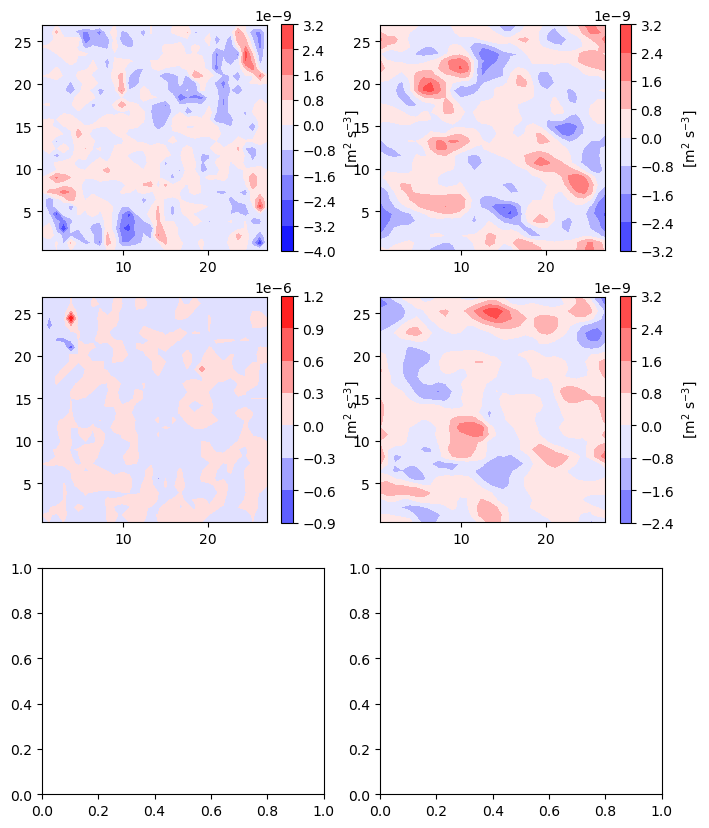

In [11]:
fig, axs = plt.subplots(len(times)+1, 2, figsize=(8, 10))

SGStransfers=[SGStransfer,SGStransfer_true]
vranges = [[[None, None], [-4e-9, 4e-9]],[[None, None], [-4e-9, 4e-9]]]
# vranges=[[-5e-7,5e-7],[-3.2e-9,3.2e-9]]
cbarLabels = [[r'[m$^2$ s$^{-3}$]',r'[m$^2$ s$^{-3}$]'],[r'[m$^2$ s$^{-3}$]',r'[m$^2$ s$^{-3}$]'],[r'[m$^2$ s$^{-3}$]',r'[m s$^{-1}$]']]

for it in range(nt):
    for iax, SGSt in enumerate(SGStransfers):
        cf = axs[it, iax].contourf(
            x, y, SGSt[it].T, cmap="bwr", vmin=vranges[it][iax][0], vmax=vranges[it][iax][1]
        )
        vmin, vmax = cf.get_clim()
        vabs = np.max([np.abs(vmin), vmax])
        cf = axs[it, iax].contourf(x, y, SGSt[it].T, cmap="bwr", vmin=-vabs, vmax=vabs)
        plt.colorbar(
            cf,
            ax=axs[it, iax],
            norm=matplotlib.colors.Normalize(vmin=-vabs, vmax=vabs),
            cmap="bwr",label=cbarLabels[it][iax]
        )
        
        print(np.mean(SGSt))
        
        axs[it,iax].set_aspect('equal')
        # ax[it,iax].set_title('7'+str(timestep)+' s',fontsize=fs)

In [12]:
times=[43]
hgt_c=[ 2.12]
# hgt_c=[ 10]
deviatoric=True

paths=[ '../cases/SBL_local_midGridReInterp/'] #'../cases/SBL_global_midGridReInterp/',
pathLabels=['Local'] # 'Global',


varStr=['u','v','w','b']
size=1
xList_local = []
yList_local = []
scalesList = []
for iLES, path in enumerate(paths):
    
    # open_mfdatset not working with this version of xarray for some reason, 
    # could install dask to fix error judging by error message
    uda=xr.open_dataset(path+varStr[0]+'_bu.nc')[varStr[0]]
    print(uda)
    vda=xr.open_dataset(path+varStr[1]+'_bu.nc')[varStr[1]]
    print(vda)
    wda=xr.open_dataset(path+varStr[2]+'_bu.nc')[varStr[2]]
    print(wda)
    bda=xr.open_dataset(path+varStr[3]+'_bu.nc')[varStr[3]]
    print(bda)
    
    # Getting grid vairables to comput grid size
    x=vda['x'].values
    y=uda['y'].values
    nbl=int(0.75*uda.shape[1])
    z=uda['z'].values[:nbl]
    dx=np.mean(np.diff(x))
    dy=np.mean(np.diff(y))
    dz=np.mean(np.diff(z))


    # Getting input variables, removing laminar layers, wrapping periodic varaibles as reordering to x,y,z,t 
    uwrap=uda[times,0:nbl].pad(xh=(1,0), mode='wrap')
    ucenter=0.5*(uwrap[:,:,:,1:].assign_coords(xh=vda['x'].values)+uwrap[:,:,:,:-1].assign_coords(xh=vda['x'].values))
    uc=ucenter.pad({'xh':(size,size),'y':(size,size)},mode='wrap').transpose().values
    u=box(uc)

    vwrap=vda[times,0:nbl].pad(yh=(1,0), mode='wrap')
    vcenter=0.5*(vwrap[:,:,1:,:].assign_coords(yh=uda['y'].values)+vwrap[:,:,:-1,:].assign_coords(yh=uda['y'].values))
    vc=vcenter.pad({'x':(size,size),'yh':(size,size)},mode='wrap').transpose().values
    v=box(vc)

    wpad=wda[:,0:nbl+1]
    wcenter=0.5*(wpad[times,1:,:,:].assign_coords(zh=z)+wpad[:,:-1,:,:].assign_coords(zh=z))
    wc=wcenter.pad({'x':(size,size),'y':(size,size)},mode='wrap').transpose().values
    w=box(wc)
    
    b=box(bda[times,0:nbl].pad({'x':(size,size),'y':(size,size)},mode='wrap').transpose().values)

    inputFields = np.array([u, v, w, b])
    
    #Gradients at grid scale for strain rate
    # d11=(uc[2:,1:-1,:,:]-uc[:-2,1:-1,:,:])/(2*dx)
    # d12=(uc[1:-1,2:,:,:]-uc[1:-1,:-2,:,:])/(2*dy)
    # d13=np.gradient(uc[1:-1,1:-1,:,:],dz,axis=2)
    
    # d21=(vc[2:,1:-1,:,:]-vc[:-2,1:-1,:,:])/(2*dx)
    # d22=(vc[1:-1,2:,:,:]-vc[1:-1,:-2,:,:])/(2*dy)
    # d23=np.gradient(vc[1:-1,1:-1,:,:],dz,axis=2)
    
    # d31=(wc[2:,1:-1,:,:]-wc[:-2,1:-1,:,:])/(2*dx)
    # d32=(wc[1:-1,2:,:,:]-wc[1:-1,:-2,:,:])/(2*dy)
    # d33=np.gradient(wc[1:-1,1:-1,:,:],dz,axis=2)

    # S11=d11
    # S12=0.5*(d12+d21)
    # S13=0.5*(d13+d31)
    # S22=d22
    # S23=0.5*(d23+d32)
    # S33=d33

    #Gradients at filter scale for TKE, TPE, and N2
    d11=(u[2:,1:-1,:,:]-u[:-2,1:-1,:,:])/(2*dx)
    d12=(u[1:-1,2:,:,:]-u[1:-1,:-2,:,:])/(2*dy)
    d13=np.gradient(u[1:-1,1:-1,:,:],dz,axis=2)

    d21=(v[2:,1:-1,:,:]-v[:-2,1:-1,:,:])/(2*dx)
    d22=(v[1:-1,2:,:,:]-v[1:-1,:-2,:,:])/(2*dy)
    d23=np.gradient(v[1:-1,1:-1,:,:],dz,axis=2)

    d31=(w[2:,1:-1,:,:]-w[:-2,1:-1,:,:])/(2*dx)
    d32=(w[1:-1,2:,:,:]-w[1:-1,:-2,:,:])/(2*dy)
    d33=np.gradient(w[1:-1,1:-1,:,:],dz,axis=2)

    # Strain at fitler scale, maybe better comparison to coarsened DNS
    S11=d11
    S12=0.5*(d12+d21)
    S13=0.5*(d13+d31)
    S22=d22
    S23=0.5*(d23+d32)
    S33=d33

        # Copmute anisotropic local scaling factors
    TKE_h = dx**2*(d11**2 + d21**2) + dy**2*(d12**2 + d22**2) + dz**2*(d13**2 + d23**2) 
    TKE_v = dx**2*d31**2 + dy**2*d32**2 + dz**2*d33**2
    TKE = TKE_h + TKE_v
    print(TKE.shape)
    #TKE = (delta**2/1.0)*dijdij
    del d11,d12,d13,d21,d22,d23,d31,d32,d33#,TKE_h

    db1=(b[2:,1:-1,:,:]-b[:-2,1:-1,:,:])/(2*dx)
    db2=(b[1:-1,2:,:,:]-b[1:-1,:-2,:,:])/(2*dy)
    db3=np.gradient(b[1:-1,1:-1,:,:],dz,axis=2)
    N2=db3
    
    #dbkdbk=db1*db1+db2*db2+db3*db3
    TPE=(dx**2*db1**2+dy**2*db2**2+dz**2*db3**2)/N2
    #TPE = (delta**2/1.0)*dbkdbk/N2
    del db1,db2,db3 
    gc.collect()

    hvelScale = np.pad(np.sqrt(TKE),((size,size),(size,size),(0,0),(0,0)),mode='wrap')
    vvelScale = np.pad(np.sqrt(TKE_v),((size,size),(size,size),(0,0),(0,0)),mode='wrap')
    bScale = np.pad(TPE/dz,((size,size),(size,size),(0,0),(0,0)),mode='wrap')
    TKEf=box(TKE,koffset=10,pad=False)
    TKEvf=box(TKE_v,koffset=10,pad=False)
    ti3Scale=np.sqrt(TKEf*TKEvf)
    tijScale=np.array([TKEf,TKEf,ti3Scale,TKEf,ti3Scale,TKEvf])
    # ti3Scale=np.sqrt(TKE*TKE_v)
    # tijScale=np.array([TKE,TKE,ti3Scale,TKE,ti3Scale,TKE_v])

    for it in range(inputFields.shape[4]):
        for i in range(size, inputFields.shape[1] - size):
            for j in range(size, inputFields.shape[2] - size):
                for k in range(size, inputFields.shape[3] - size):                
                    ## Local Scaling 
                    scaledInput=[scale(inputFields[0,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=hvelScale[i, j, k, it]),
                                 scale(inputFields[1,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=hvelScale[i, j, k, it]),
                                 scale(inputFields[2,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=vvelScale[i, j, k, it]),
                                 scale(inputFields[3,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=bScale[i, j, k, it])]
                    xList_local.append(scaledInput)
                    scalesList.append(tijScale[:,i-size,j-size,k,it])
                    # yList_local.append(outputFields[:,i-size,j-size,k,it]/tijScale[:,i-size,j-size,k,it])

x3d=np.array(xList_local)
scales=np.array(scalesList)
xlocal=myreshape(x3d,size=2*size+1)

<xarray.DataArray 'u' (time: 44, z: 64, y: 32, xh: 32)> Size: 23MB
[2883584 values with dtype=float64]
Coordinates:
  * time     (time) float64 352B 700.0 701.0 702.0 703.0 ... 741.0 742.0 743.0
  * z        (z) float64 512B 0.1412 0.4236 0.706 0.9885 ... 17.37 17.65 17.93
  * y        (y) float64 256B 0.4279 1.284 2.14 2.995 ... 24.39 25.25 26.1 26.96
  * xh       (xh) float64 256B 0.0 0.8558 1.712 2.567 ... 24.82 25.67 26.53
<xarray.DataArray 'v' (time: 44, z: 64, yh: 32, x: 32)> Size: 23MB
[2883584 values with dtype=float64]
Coordinates:
  * time     (time) float64 352B 700.0 701.0 702.0 703.0 ... 741.0 742.0 743.0
  * z        (z) float64 512B 0.1412 0.4236 0.706 0.9885 ... 17.37 17.65 17.93
  * x        (x) float64 256B 0.4279 1.284 2.14 2.995 ... 24.39 25.25 26.1 26.96
  * yh       (yh) float64 256B 0.0 0.8558 1.712 2.567 ... 24.82 25.67 26.53
<xarray.DataArray 'w' (time: 44, zh: 64, y: 32, x: 32)> Size: 23MB
[2883584 values with dtype=float64]
Coordinates:
  * time     (time) fl

In [13]:
nt=len(times)
for it in range(nt):
    ylocal = get_xyplane_model(model, xlocal, scales, nx, ny, nz, nt, kplot, it)

    if deviatoric:
        third_trace = (ylocal[:, :, 0] + ylocal[:, :, 3] + ylocal[:, :, 5]) / 3
        for inormal in [0, 3, 5]:
            ylocal[:, :, inormal] -= third_trace

    SGStransfer=( ylocal[:,:,0]*S11[:,:,kplot,0]+2*ylocal[:,:,1]*S12[:,:,kplot,0]+2*ylocal[:,:,2]*S13[:,:,kplot,0]
             +ylocal[:,:,3]*S22[:,:,kplot,0]+2*ylocal[:,:,4]*S23[:,:,kplot,0]+ylocal[:,:,5]*S33[:,:,kplot,0])

In [14]:
it=2
iax=0
cf = axs[it, iax].contourf(
    x, y, SGStransfer.T, cmap="bwr"#, vmin=vranges[iax][0], vmax=vranges[iax][1]
)
vmin, vmax = cf.get_clim()
vabs = np.max([np.abs(vmin), vmax])
cf = axs[it, iax].contourf(x, y, SGStransfer.T, cmap="bwr", vmin=-vabs, vmax=vabs)
plt.colorbar(
    cf,
    ax=axs[it, iax],
    norm=matplotlib.colors.Normalize(vmin=-vabs, vmax=vabs),
    cmap="bwr",label=cbarLabels[it][iax]
)
print(np.mean(SGSt))

axs[it,iax].set_aspect('equal')
# ax[it,iax].set_title('7'+str(timestep)+' s',fontsize=fs)

-2.5687896459649288e-11


<Figure size 640x480 with 0 Axes>

-2.5687896459649288e-11


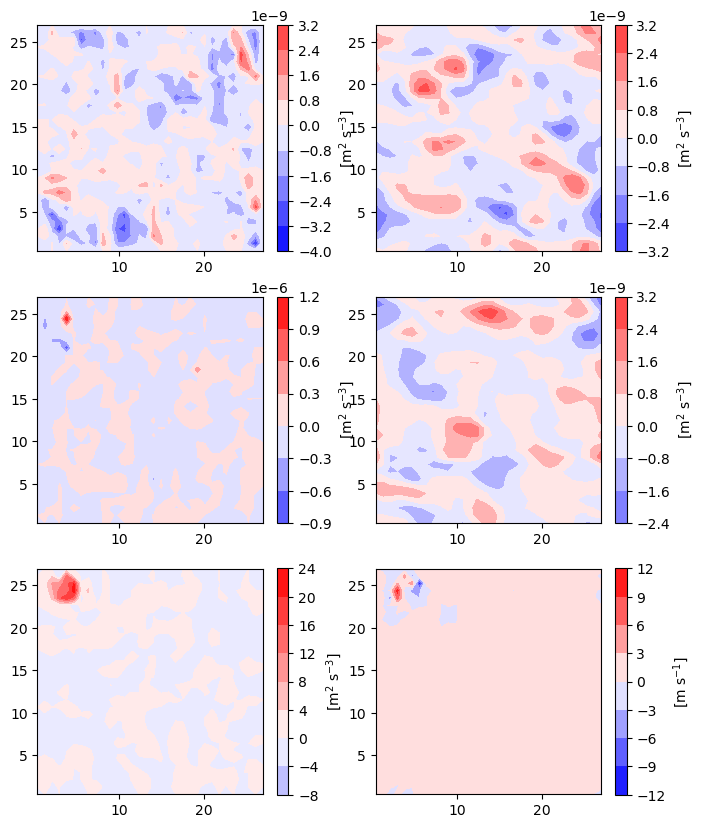

<Figure size 640x480 with 0 Axes>

In [15]:
it=2
iax=1
cf = axs[it, iax].contourf(
    x, y, uda[times[0],kplot], cmap="bwr"#, vmin=vranges[iax][0], vmax=vranges[iax][1]
)
vmin, vmax = cf.get_clim()
vabs = np.max([np.abs(vmin), vmax])
cf = axs[it, iax].contourf(x, y, uda[times[0],kplot], cmap="bwr")#, vmin=-vabs, vmax=vabs)
plt.colorbar(
    cf,
    ax=axs[it, iax],
    norm=matplotlib.colors.Normalize(vmin=-vabs, vmax=vabs),
    cmap="bwr",label=cbarLabels[it][iax]
)
print(np.mean(SGSt))

axs[it,iax].set_aspect('equal')
# ax[it,iax].set_title('7'+str(timestep)+' s',fontsize=fs)'
fig

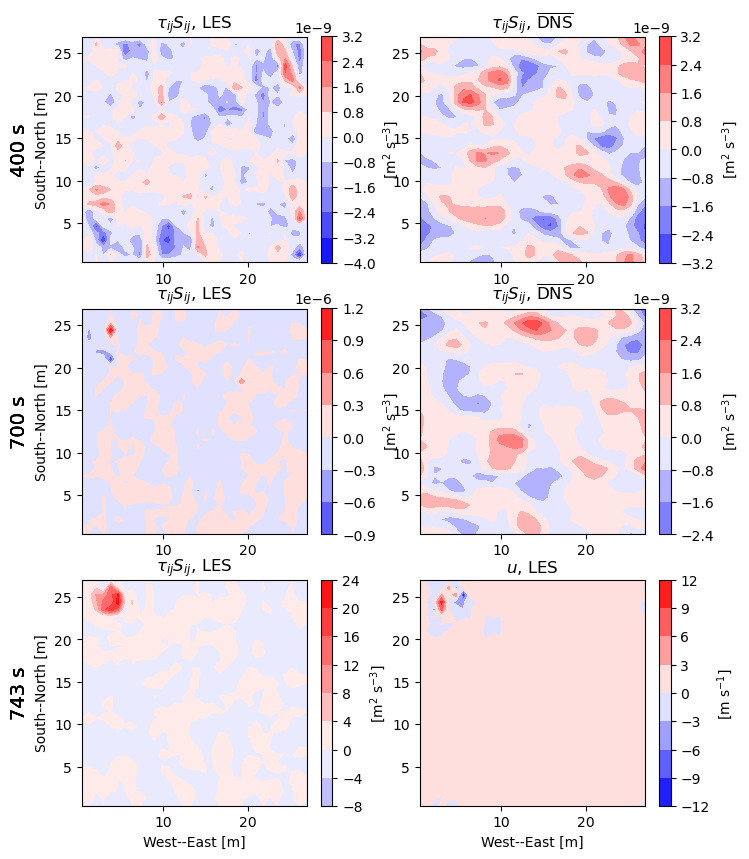

In [21]:
pad=0
varNames = [[r'$\tau_{ij}S_{ij}$, LES', r'$\tau_{ij}S_{ij}$, $\overline{\text{DNS}}$'], [r'$\tau_{ij}S_{ij}$, LES', r'$\tau_{ij}S_{ij}$, $\overline{\text{DNS}}$'],[r'$\tau_{ij}S_{ij}$, LES', r'$u$, LES']]

for it in range(3):
    axs[it,0].annotate(timeStr[it], xy=(0, 0.5), xytext=(-axs[it,0].yaxis.labelpad - pad, 0),
        xycoords=axs[it,0].yaxis.label, textcoords='offset points',
        size=14, ha='right', va='center',rotation=90)
    for iax in range(2):
        axs[it,iax].set_title(varNames[it][iax])
        axs[it,iax].tick_params(labelsize=10)

    axs[it,0].set_ylabel('South--North [m]',fontsize=10)
axs[it,0].set_xlabel('West--East [m]',fontsize=10)
axs[it,1].set_xlabel('West--East [m]',fontsize=10)


fig      

In [22]:
save=True
if save:
    plt.figure(fig)
    fmts=["png","eps"]
    for fmt in fmts:
        plt.savefig("XYcontour_SGStranfer_interp."+fmt, format=fmt)

In [ ]:

# cb=fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap='bwr'),ax=ax.ravel().tolist())
# # fig.tight_layout()      
# fig

In [17]:
# plt.hist(SGStransfer.flatten(),bins=300)

In [ ]:
# path_dns='/glade/u/home/adac/work/DNSdata/DNS_SBL_L320/Re1800/'

# # timesteps=[616000]
# timesteps=[623000]
# # timesteps=[630000]
# nt=len(timesteps)

# ds = xr.open_dataset(path_dns+var+str(timesteps[0])+'.nc',decode_times=0)
# print(ds)

# w=ds[var][0].values

# try:
#   x=ds['xh'].values
# except:
#   x=ds['x'].values
# nx=len(x)

# try:
#   y=ds['yh'].values
# except:
#   y=ds['y'].values
# ny=len(y)

# try:
#   z=ds['zh'].values
#   hgts=hgts_h
# except:
#   z=ds['z'].values
#   hgts=hgts_c

In [ ]:
# for hgt in hgts:
#     k = np.abs(z - hgt).argmin()
#     for it, timestep in enumerate(timesteps):
#         fig, ax = plt.subplots(2,2,figsize = (12, 10))

#         ds = xr.open_dataset(path_dns+var+str(timestep)+'.nc',decode_times=0)
#         print(ds)

#         w=ds[var][0].values

#         ax[0,0].contourf(x,y,w[k],vmin=vmin,vmax=vmax,cmap=colormap)
#         ax[0,0].set_aspect('equal')
#         ax[0,0].set_title('DNS',fontsize=fs)

In [ ]:
# #fig.suptitle('Vertical velocity at '+str(int(zplot))+' m above ground, time='+str(timesteps[i])+' s')
# fig.savefig('wXYcontour_k'+str(k)+'_z'+str(int(hgt))+'_t'+str(timestep)+'.png',format='png',transparent=True)
# plt.show()
# plt.close(fig)

In [ ]:
# for i in range(nt):

#     ds = xr.open_dataset(path_dns+'w'+str(timesteps[i])+'.nc',decode_times=0)
#     da=ds['w'][0]

#     x=ds['x'].values
#     #print(x[0])
#     #print(x[-1])
#     y=ds['y'].values
#     z=ds['zh'].values

#     kplot = np.abs(zcoarse - 10).argmin()

#     nz=len(zcoarse)
#     for kcoarse in [kplot]:#range(nz):

#         ucoarse=dacoarse.sel(time=timesteps[i])[kcoarse].values
#         ucoarse=np.insert(ucoarse,0,(ucoarse[:,-1]+ucoarse[:,0])/2.0,axis=1)
#         ucoarse=np.column_stack((ucoarse,ucoarse[:,0]))#,axis=1)
#         ucoarse=np.insert(ucoarse,0,(ucoarse[-1,:]+ucoarse[0,:])/2.0,axis=0)
#         ucoarse=np.row_stack((ucoarse,ucoarse[0,:]))#,axis=0)

#         zplot=zcoarse[kcoarse]
#         k = np.abs(z - zplot).argmin()
#         u=da[k].values

#         fig,ax = plt.subplots(1,2,figsize = (20, 8))
#         ax[0].contourf(x,y,u,vmin=vmin,vmax=vmax,cmap='bwr')
#         ax[0].set_aspect('equal')
#         ax[0].set_title('High resolution',fontsize=48)
#         ax[0].set_ylabel('South--North [m]',fontsize=20)
#         ax[0].set_xlabel('West--East [m]',fontsize=20)
#         ax[0].tick_params(labelsize=18)
        
#         im=ax[1].contourf(xcoarse,ycoarse,ucoarse,vmin=vmin,vmax=vmax,cmap='bwr')
#         ax[1].set_aspect('equal')
#         ax[1].set_title('Coarse resolution',fontsize=48)
#         ax[1].set_ylabel('South--North [m]',fontsize=20)
#         ax[1].set_xlabel('West--East [m]',fontsize=20)
#         ax[1].tick_params(labelsize=18)
        
#         #fig.subplots_adjust(right=0.8)
#         #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#         #cbar_ax.set_visible(False)
#         cb=fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap='bwr'),ax=ax.ravel().tolist())
#         #cb.set_clim(vmin=-0.004,vmax=0.004)
#         #.clim(-0.004,0.004)
#         cb.ax.tick_params(labelsize=18)
#         cb.set_label(label='Vertical Velocity [m s$^{-1}$]',fontsize=32)

#         #fig.suptitle('Vertical velocity at '+str(int(zplot))+' m above ground, time='+str(timesteps[i])+' s')
#         fig.savefig('wXYcontour_k'+str(k)+'_z'+str(int(zplot))+'_t'+str(timesteps[i])+'.png',format='png',transparent=True)
#         plt.show()
#         plt.close(fig)
